# R mixed effect modeling tutorial

https://github.com/ourcodingclub/CC-Linear-mixed-models

https://ourcodingclub.github.io/tutorials/mixed-models/

authors: Gabriela K Hajduk, based on workshop developed by Liam Bailey

contact details: gkhajduk.github.io; email: gkhajduk@gmail.com

date: 2017-03-09

Created by Gabriela K Hajduk - last updated 9th February 2022 by Elise Gallois

This work is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](https://creativecommons.org/licenses/by-sa/4.0/).

*Revised and adapted by Andrew Chang (Feb 3, 2023)*

## 1. What is mixed effects modelling and why does it matter?
Ecological and biological data are often complex and messy. We can have different **grouping factors** like populations, species, sites where we collect the data, etc. Sample sizes might leave something to be desired too, especially if we are trying to fit complicated models with **many parameters**. On top of that, our data points might not be truly independent. For instance, we might be using quadrats within our sites to collect the data (and so there is structure to our data: quadrats are nested within the sites).

This is why **mixed models** were developed, to deal with such messy data and to allow us to use all our data, even when we have low sample sizes, structured data and many covariates to fit. Oh, and on top of all that, mixed models allow us to save degrees of freedom compared to running standard linear models! Sounds good, doesn’t it?

We will cover only linear mixed models here, but if you are trying to “extend” your linear model, fear not: there are generalised linear mixed effects models out there, too.

## 2. Data exploration

load the data and have a look at it

In [34]:
load("dragons.RData")
head(dragons)

,testScore,bodyLength,mountainRange,X,site
,<dbl>,<dbl>,<fct>,<lgl>,<fct>
1,16.147309,165.5485,Bavarian,NA,a
2,33.886183,167.5593,Bavarian,NA,a
3,6.038333,165.8830,Bavarian,NA,a
4,18.838821,167.6855,Bavarian,NA,a
5,33.862328,169.9597,Bavarian,NA,a
6,47.043246,168.6887,Bavarian,NA,a


In [35]:
library(psych)
describe(dragons)

ERROR: Error in describe(dragons): could not find function "describe"


Let's say we want to know how the body length affects test scores.

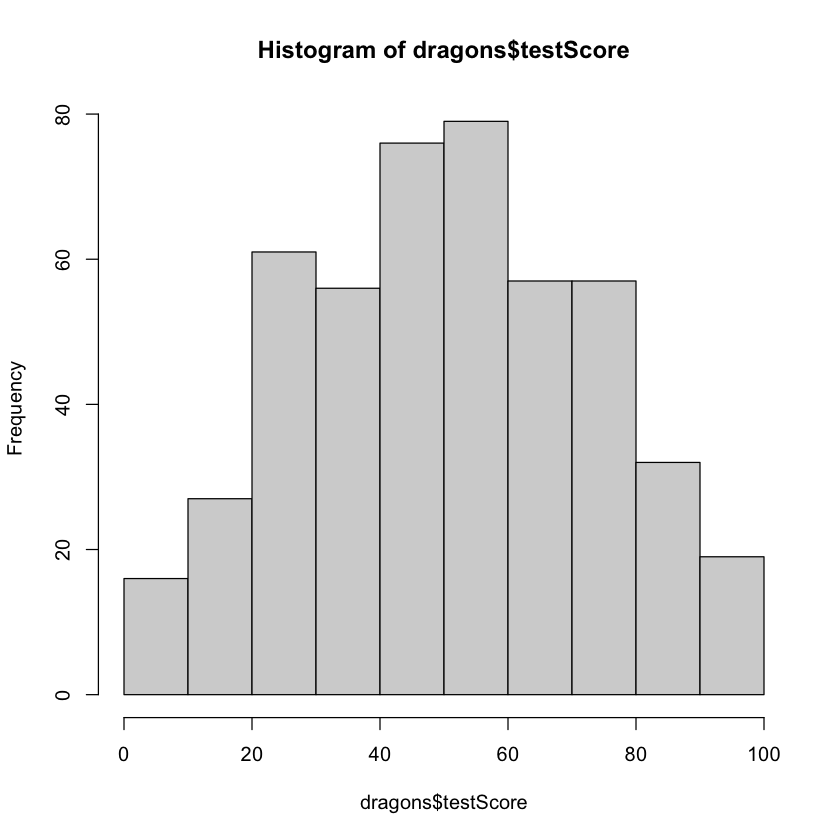

In [2]:
## Have a look at the data distribution:

hist(dragons$testScore)  # seems close to normal distribution - good!

In [6]:
## You can standardize your explanatory variables before proceeding - you can use scale() to do that:
dragons$bodyLength2 <- scale(dragons$bodyLength, center = TRUE, scale = TRUE)

## 3. Fit all data in one analysis

One way to analyse this data would be to try fitting a linear model to all our data, ignoring the sites and the mountain ranges for now.

In [4]:
basic.lm <- lm(testScore ~ bodyLength2, data = dragons)
summary(basic.lm)

Loading required package: Matrix




Call:
lm(formula = testScore ~ bodyLength2, data = dragons)

Residuals:
    Min      1Q  Median      3Q     Max 
-56.962 -16.411  -0.783  15.193  55.200 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  50.3860     0.9676  52.072   <2e-16 ***
bodyLength2   8.9956     0.9686   9.287   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 21.2 on 478 degrees of freedom
Multiple R-squared:  0.1529,	Adjusted R-squared:  0.1511 
F-statistic: 86.25 on 1 and 478 DF,  p-value: < 2.2e-16


`geom_smooth()` using formula = 'y ~ x'


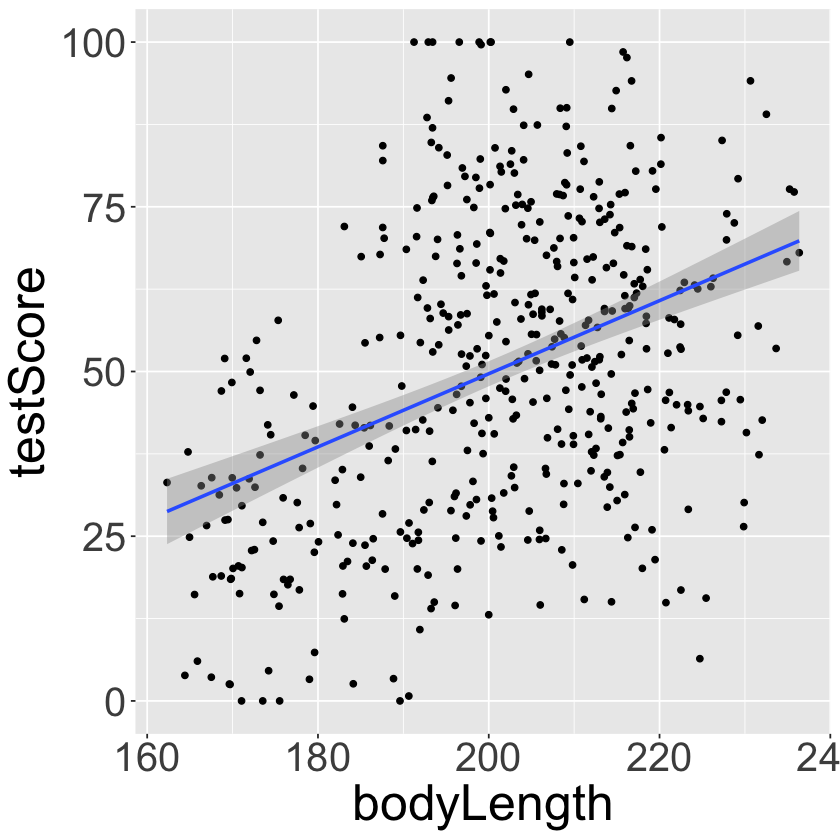

In [15]:
library(tidyverse)  # load the package containing both ggplot2 and dplyr

(prelim_plot <- ggplot(dragons, aes(x = bodyLength, y = testScore)) +
  geom_point() +
  geom_smooth(method = "lm") +
  theme(text = element_text(size = 30)))
# Note that putting your entire ggplot code in brackets () creates the graph and then shows it in the plot viewer

### Assumptions?

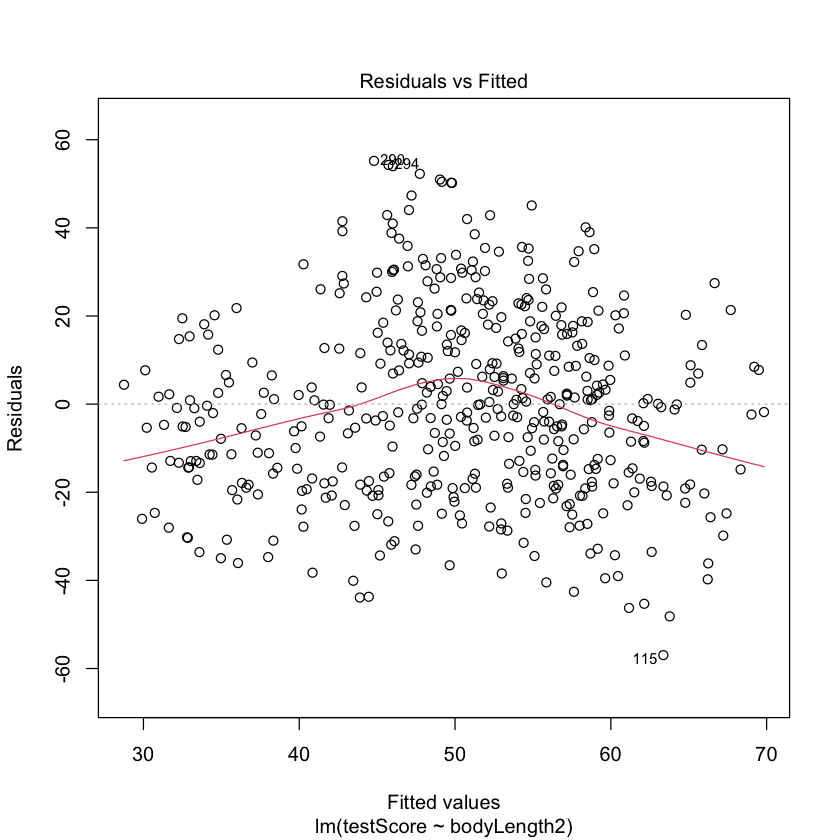

In [8]:
## Plot the residuals - the red line should be close to being flat, like the dashed grey line

plot(basic.lm, which = 1)  # not perfect, but look alright

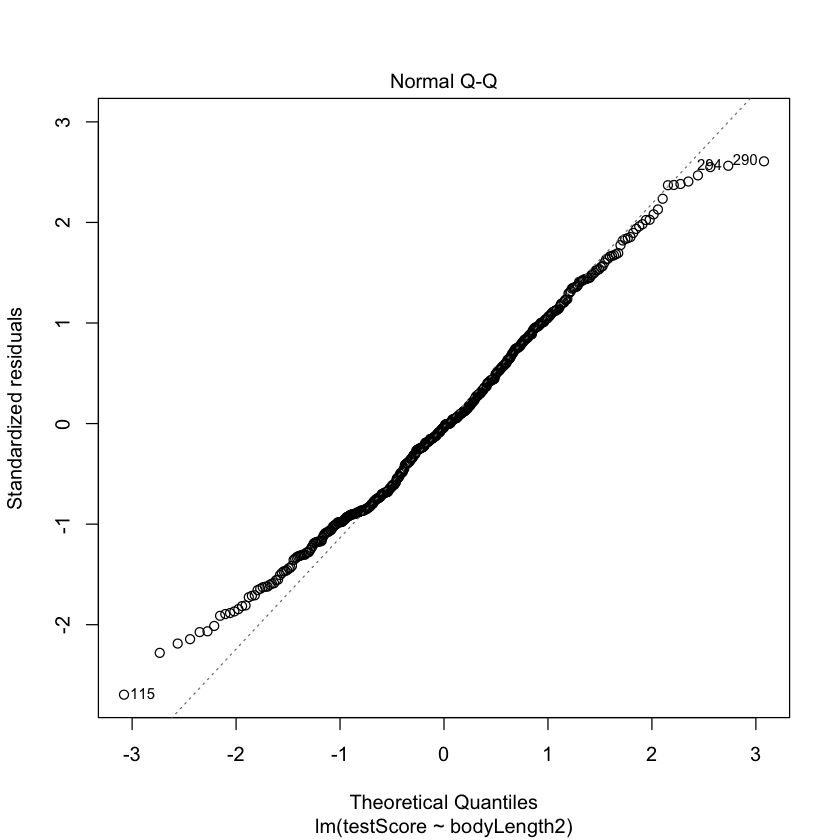

In [9]:
## Have a quick look at the  qqplot too - point should ideally fall onto the diagonal dashed line

plot(basic.lm, which = 2)  # a bit off at the extremes, but that's often the case; again doesn't look too bad

## However, what about observation independence? Are our data independent?
We collected multiple samples from eight mountain ranges. It's perfectly plausible that the data from within each mountain range are more similar to each other than the data from different mountain ranges - they are correlated. Pseudoreplication isn't our friend.

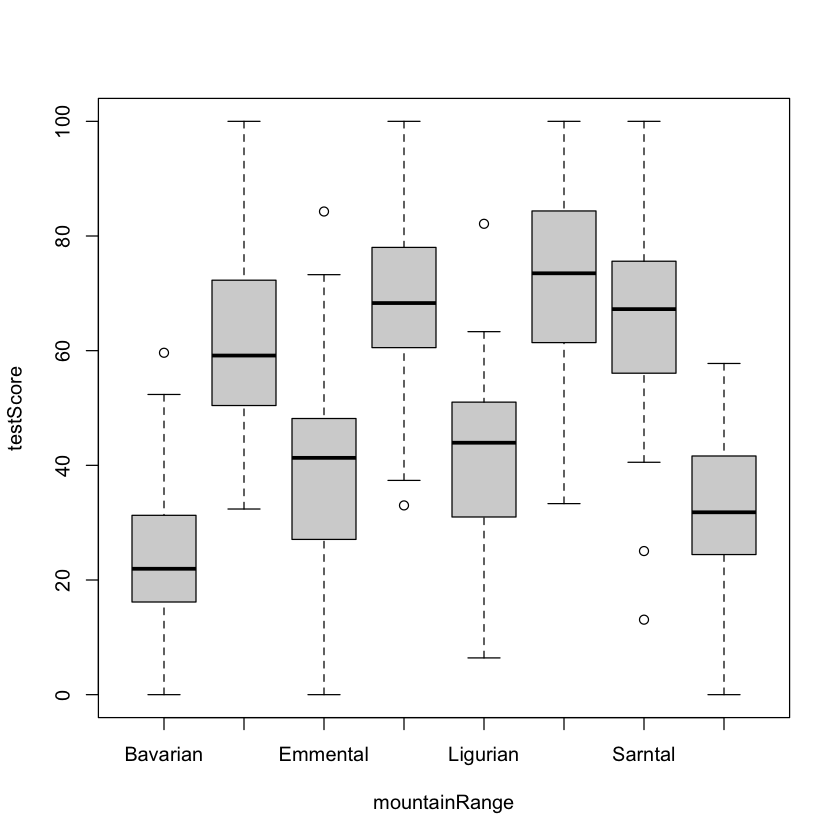

In [10]:
## Have a look at the data to see if above is true
boxplot(testScore ~ mountainRange, data = dragons)  # certainly looks like something is going on here

We could also plot it and colour points by mountain range

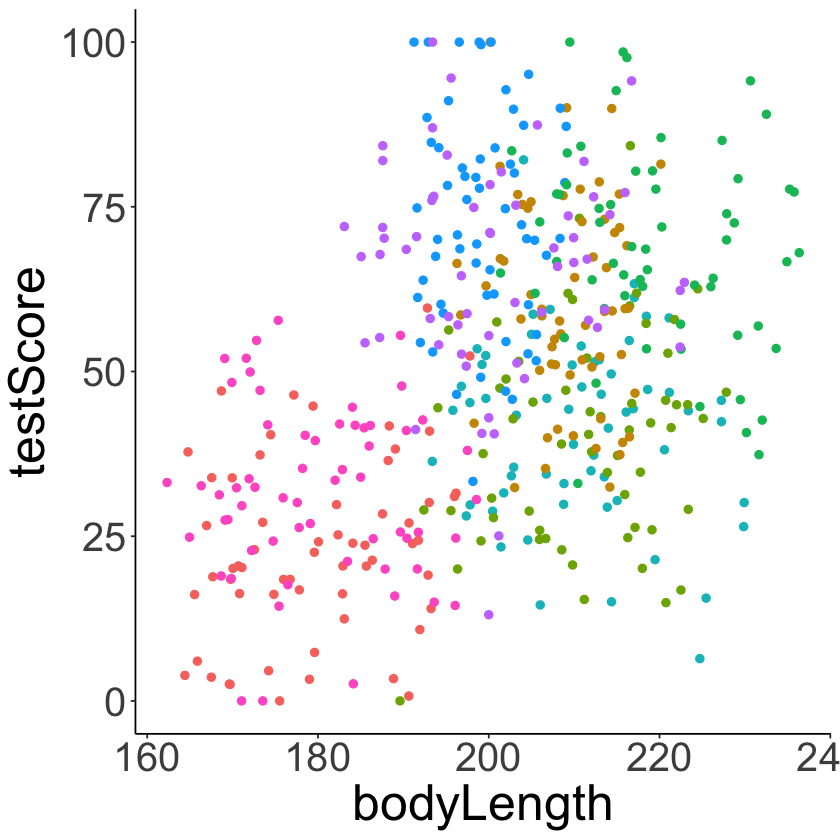

In [14]:
(colour_plot <- ggplot(dragons, aes(x = bodyLength, y = testScore, colour = mountainRange)) +
  geom_point(size = 2) +
  theme_classic() +
  theme(legend.position = "none", text = element_text(size = 30)))

From the above plots, it looks like our mountain ranges vary both in the dragon body length **AND** in their test scores. This confirms that our observations from within each of the ranges **aren’t independent**. We can’t ignore that: as we’re starting to see, it could lead to a completely erroneous conclusion.

So what do we do?

## 4. Run multiple analyses
We could run many separate analyses and fit a regression for each of the mountain ranges.
Lets have a quick look at the data split by mountain range. We use the ```facet_wrap``` to do that:

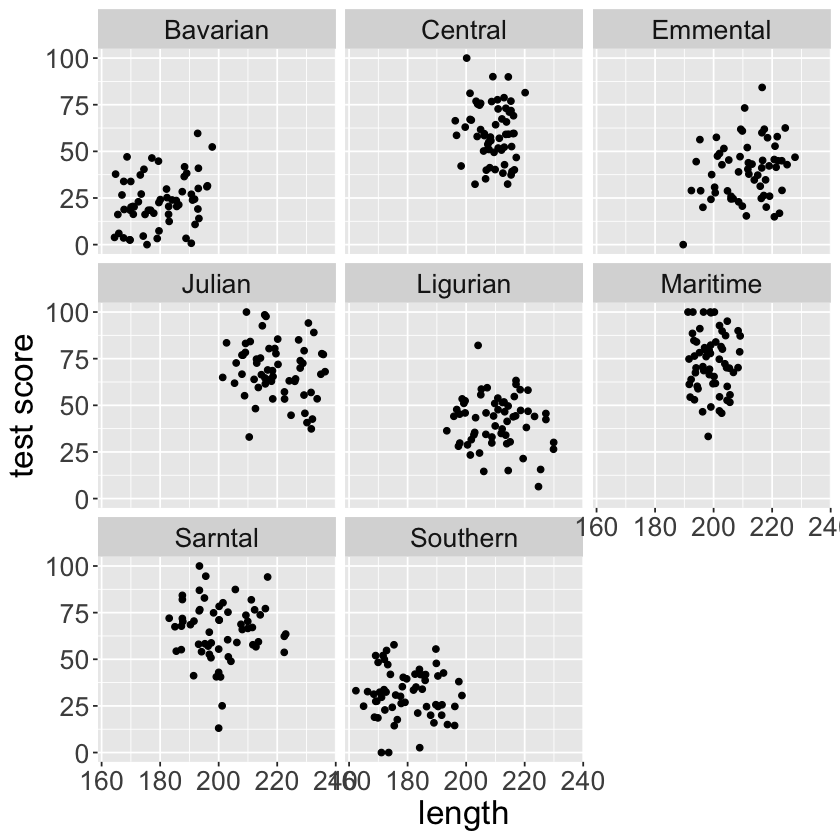

In [18]:
(split_plot <- ggplot(aes(bodyLength, testScore), data = dragons) + 
  geom_point() + 
  facet_wrap(~ mountainRange) + # create a facet for each mountain range
  xlab("length") + 
  ylab("test score") +
  theme(legend.position = "none", text = element_text(size = 20)))

That’s eight analyses. Oh wait, we also have different sites in each mountain range, which similarly to mountain ranges aren’t independent… So we could run an analysis for each site in each range separately.

To do the above, we would have to estimate a slope and intercept parameter for **each regression**. That’s two parameters, three sites and eight mountain ranges, which means **48 parameter estimates** (2 x 3 x 8 = 48)! Moreover, the sample size for each analysis would be only 20 (dragons per site).

This presents problems: not only are we **hugely decreasing our sample size**, but we are also **increasing chances of a Type I Error (where you falsely reject the null hypothesis) by carrying out multiple comparisons**. Not ideal!

## 5. Modify the current model

We want to use all the data, but account for the data coming from different mountain ranges (let’s put sites on hold for a second to make things simpler).

Add mountain range as a fixed effect to our ```basic.lm```

In [19]:
mountain.lm <- lm(testScore ~ bodyLength2 + mountainRange, data = dragons)
summary(mountain.lm)


Call:
lm(formula = testScore ~ bodyLength2 + mountainRange, data = dragons)

Residuals:
    Min      1Q  Median      3Q     Max 
-52.263  -9.926   0.361   9.994  44.488 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            23.3818     2.5792   9.065  < 2e-16 ***
bodyLength2             0.2055     1.2927   0.159  0.87379    
mountainRangeCentral   36.5828     3.5993  10.164  < 2e-16 ***
mountainRangeEmmental  16.2092     3.6966   4.385 1.43e-05 ***
mountainRangeJulian    45.1147     4.1901  10.767  < 2e-16 ***
mountainRangeLigurian  17.7478     3.6736   4.831 1.84e-06 ***
mountainRangeMaritime  49.8813     3.1392  15.890  < 2e-16 ***
mountainRangeSarntal   41.9784     3.1972  13.130  < 2e-16 ***
mountainRangeSouthern   8.5196     2.7313   3.119  0.00192 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 14.96 on 471 degrees of freedom
Multiple R-squared:  0.5843,	Adjusted R-squared:  0.5773 
F

Now body length is *not significant*. But let’s think about what we are doing here for a second. The above model is estimating the difference in test scores between the mountain ranges - we can see all of them in the model output returned by `summary()`. But we are not interested in quantifying test scores for each specific mountain range: we just want to know whether body length affects test scores and we want to **simply control for the variation coming from mountain ranges**.

This is what we refer to as **“random factors”** and so we arrive at mixed effects models. Ta-daa!

## 6. Mixed effects models

A mixed model is a good choice here: it will allow us to **use all the data we have** (larger sample size) and **account for the correlations between data** coming from the sites and mountain ranges. We will also **estimate fewer parameters and avoid problems with multiple comparisons** that we would encounter while using separate regressions.

We are going to work in `lme4`, so load the package (or use `install.packages` if you don’t have `lme4` on your computer).

In [20]:
library(lme4)

### First mixed model

We have a response variable, the test score and we are attempting to explain part of the variation in test score through fitting body length as a fixed effect. But the response variable has some residual variation (i.e. unexplained variation) associated with mountain ranges. By using random effects, we are modeling that unexplained variation through variance.

Note that our question changes slightly here: while we still want to know whether there is an association between dragon’s body length and the test score, we want to know if that association exists **after controlling for the variation in mountain ranges**.

We will fit the random effect using the syntax `(1|variableName)`. Whatever is on the right side of the `|` operator is a factor and referred to as a “grouping factor” for the term.

In [21]:
mixed.lmer <- lmer(testScore ~ bodyLength2 + (1|mountainRange), data = dragons)
summary(mixed.lmer)

Linear mixed model fit by REML ['lmerMod']
Formula: testScore ~ bodyLength2 + (1 | mountainRange)
   Data: dragons

REML criterion at convergence: 3985.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4815 -0.6513  0.0066  0.6685  2.9583 

Random effects:
 Groups        Name        Variance Std.Dev.
 mountainRange (Intercept) 339.7    18.43   
 Residual                  223.8    14.96   
Number of obs: 480, groups:  mountainRange, 8

Fixed effects:
            Estimate Std. Error t value
(Intercept)  50.3860     6.5517   7.690
bodyLength2   0.5377     1.2750   0.422

Correlation of Fixed Effects:
            (Intr)
bodyLength2 0.000 

The **random effect part** tells you how much variance you find among levels of your grouping factor(s), plus the residual variance.

The **fixed effect part** is very similar to a linear model output.

Once we account for the mountain ranges, it’s obvious that dragon body length doesn’t actually explain the differences in the test scores.

Take a look at the summary output: notice how the model estimate is smaller than its associated error? That means that the effect, or slope, cannot be distinguised from zero.

Keep in mind that the random effect of the mountain range is **meant to capture all the influences of mountain ranges on dragon test scores** - whether we observed those influences explicitly or not, whether those influences are big or small etc. It could be many, many teeny-tiny influences that, when combined, affect the test scores and that’s what we are hoping to control for.

We can see the variance for `mountainRange = 339.7`. Mountain ranges are clearly important: they explain a lot of variation. How do we know that? We can take the variance for the mountainRange and divide it by the total variance:

In [29]:
cat("mountain ranges explain", 339.7/(339.7 + 223.8)*100, "% of the variance that's left over after the variance expained by our fixed effects.")

mountain ranges explain 60.28394 % of the variance that's left over after the variance expained by our fixed effects.

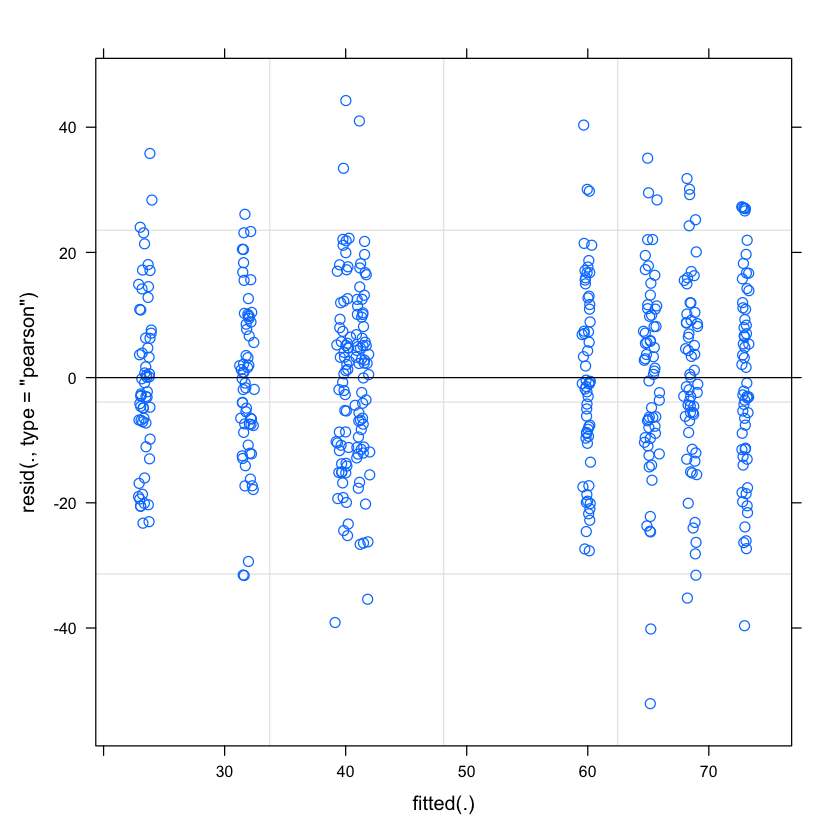

In [30]:
# As always, it’s good practice to have a look at the plots to check our assumptions:
plot(mixed.lmer)  # looks alright, no patterns evident

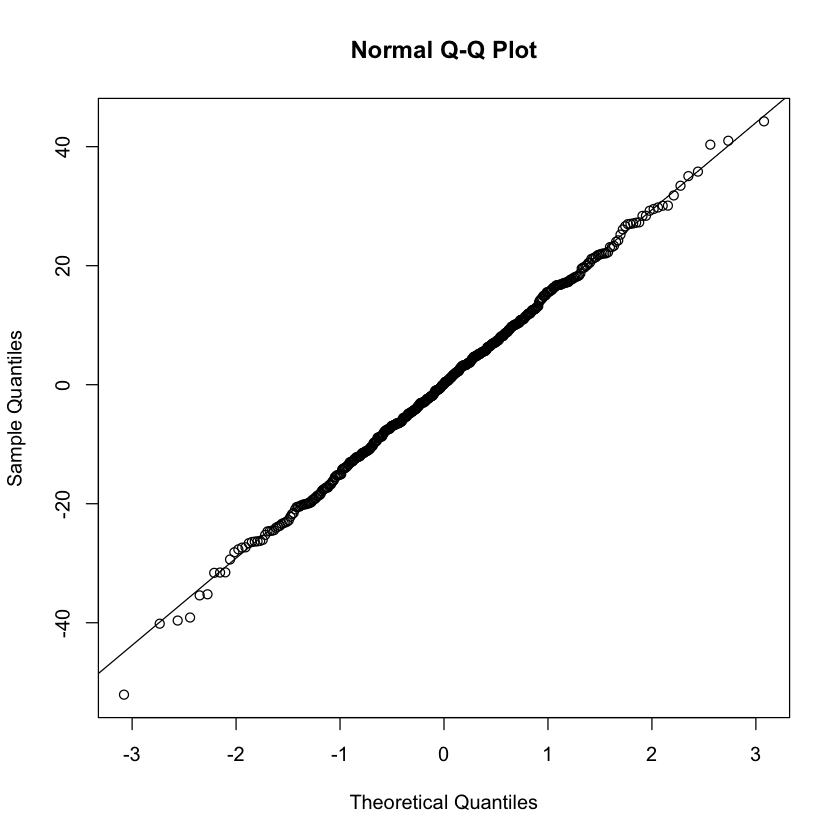

In [31]:
qqnorm(resid(mixed.lmer))
qqline(resid(mixed.lmer))  # points fall nicely onto the line - good!

### Types of random effects
Random effects (factors) can be **crossed** or **nested** - it depends on the relationship between the variables.

### *Crossed random effects*
An effect is (fully) crossed when all the subjects have experienced all the levels of that effect.